In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from keras.callbacks import EarlyStopping
from datetime import datetime
import mlflow
import mlflow.pyfunc
import yaml

In [40]:
from libs.ts_forecasting import *
from libs.postgres_functions import *

In [41]:
# Load general configurations
with open('config/general_config.yaml', 'r') as file:
    general_config = yaml.safe_load(file)

# Load project-specific configurations
with open('config/project_config.yaml', 'r') as file:
    project_config = yaml.safe_load(file)

In [42]:
print("General Configurations Loaded:\n")
print(general_config)

General Configurations Loaded:

{'model_name': 'dummy_data', 'model_artifact_name': 'TSMixerModel3', 'experiment_version': '0.1', 'production_version': '0.1', 'features': ['linear', 'exponential', 'sinusoidal'], 'csv_paths': ['datasets/dummy_linear_distinct.csv', 'datasets/dummy_exponential_distinct.csv', 'datasets/dummy_sinusoidal_distinct.csv'], 'register_experiment': False, 'register_model': False, 'train_size': 0.8, 'epochs': 50, 'batch_size': 8, 'patience': 5, 'look_back': 10, 'stage': 'Production'}


In [43]:
print("\nProject Level Configurations Loaded:\n")
print(project_config)


Project Level Configurations Loaded:

{'years': [2019, 2020, 2021, 2022, 2023], 'points_per_year': [10, 10, 10, 10, 8]}


# Data Loading

In [44]:
# List to contain the datasets we load
dataframe_list = []

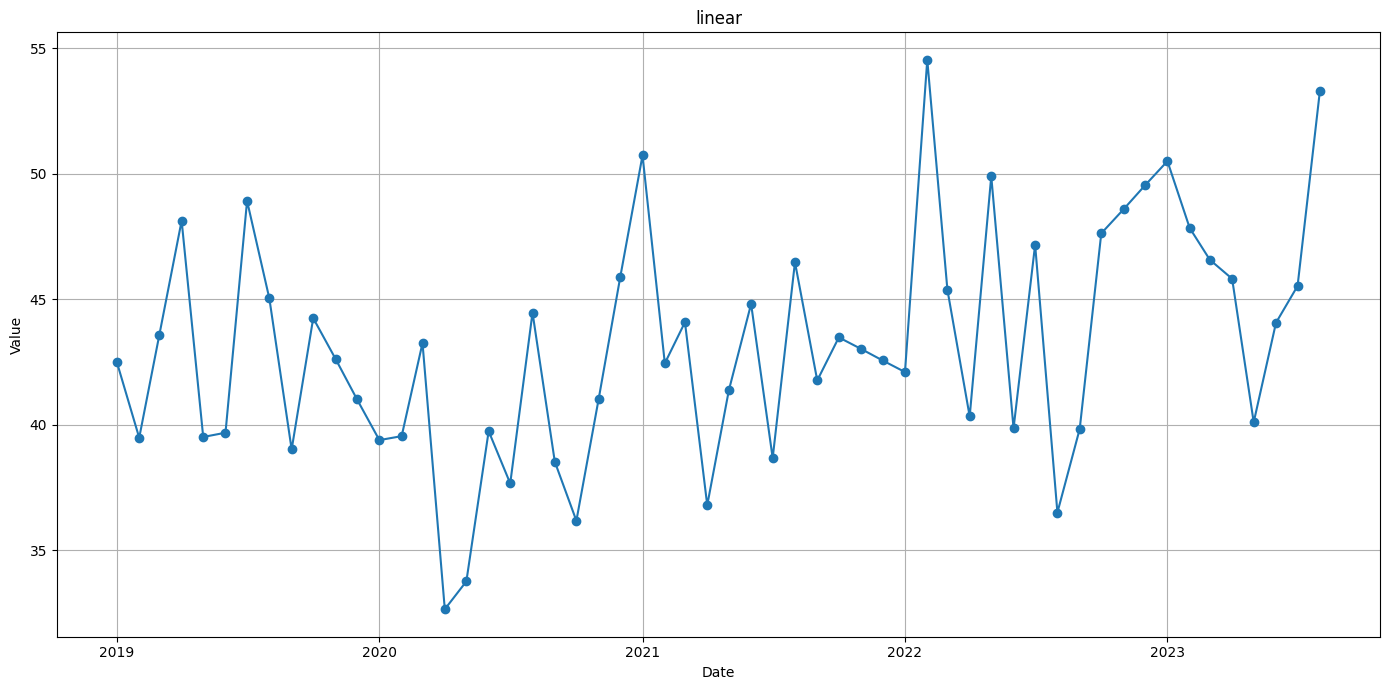

In [45]:
data_1 = load_and_preprocess_data(general_config['csv_paths'][0], 
                                  general_config['features'][0], 
                                  project_config['years'], 
                                  project_config['points_per_year'])
dataframe_list.append(data_1)
plot_loaded_data(data_1, general_config['features'][0], "Value")

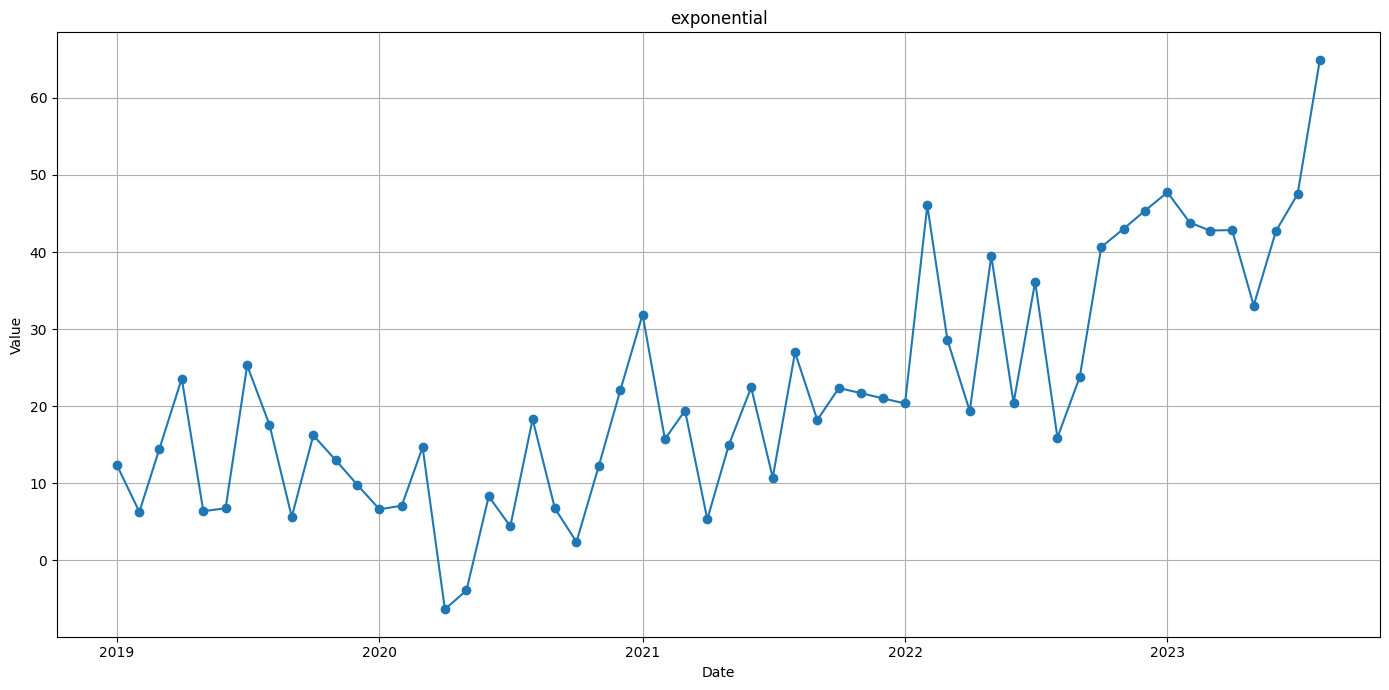

In [46]:
data_2 = load_and_preprocess_data(general_config['csv_paths'][1], 
                                  general_config['features'][1], 
                                  project_config['years'], 
                                  project_config['points_per_year'])

dataframe_list.append(data_2)
plot_loaded_data(data_2, general_config['features'][1], "Value")

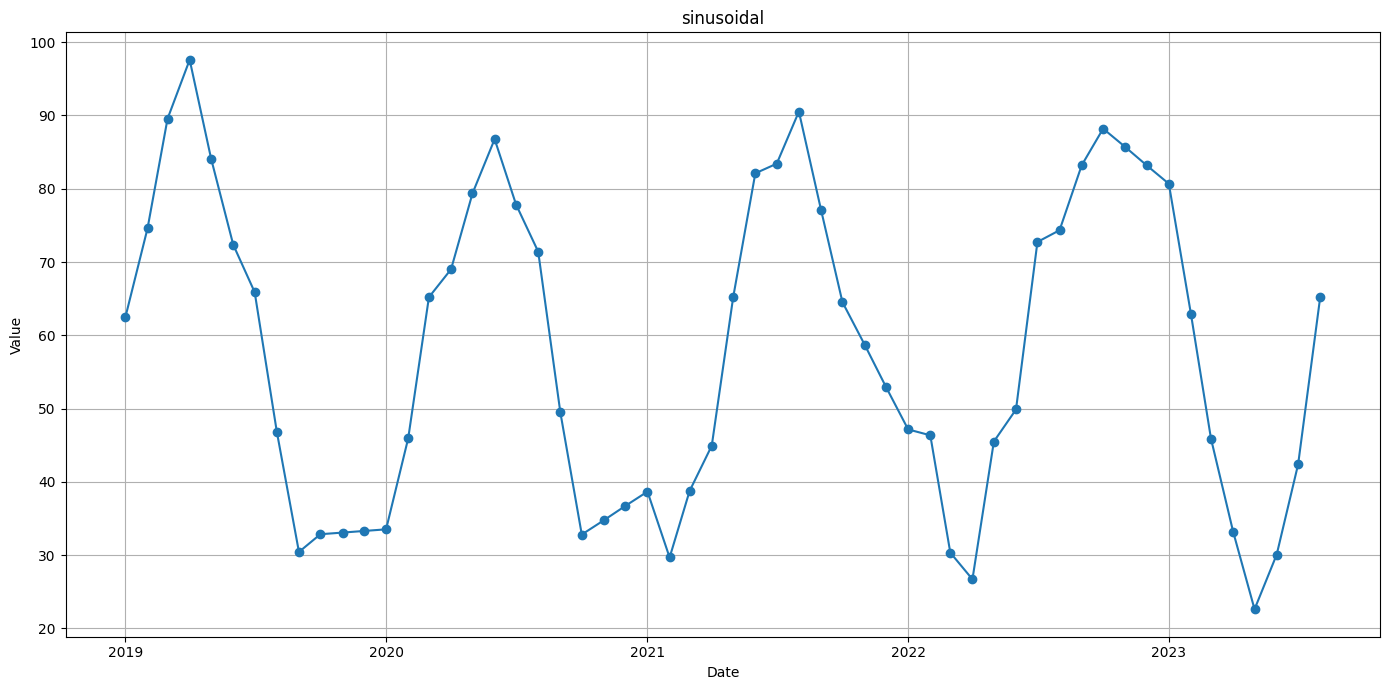

In [47]:
data_3 = load_and_preprocess_data(general_config['csv_paths'][2], 
                                  general_config['features'][2], 
                                  project_config['years'], 
                                  project_config['points_per_year'])

dataframe_list.append(data_3)
plot_loaded_data(data_3, general_config['features'][2], "Value")

In [48]:
# data_4 = load_and_preprocess_data(general_config['csv_paths'][3], 
#                                   general_config['features'][3], 
#                                   project_config['years'], 
#                                   project_config['points_per_year'])

# dataframe_list.append(data_4)
# plot_loaded_data(data_4, general_config['features'][3], "Value")

In [49]:
# data_5 = load_and_preprocess_data(general_config['csv_paths'][4], 
#                                   general_config['features'][4], 
#                                   project_config['years'], 
#                                   project_config['points_per_year'])

# dataframe_list.append(data_5)
# plot_loaded_data(data_5, general_config['features'][4], "Value")

In [50]:
# Combine data for model training
combined_dataframe = pd.concat(dataframe_list, axis=1)
data = combined_dataframe.copy()
data.columns = general_config['features']

# Keep a copy of the original data for later purposes
data_original = data.copy()

In [51]:
data.head()

,linear,exponential,sinusoidal
2019-01-01,42.4836,12.3247,62.4836
2019-02-01,39.4789,6.2948,74.5968
2019-03-01,43.5789,14.4881,89.5466
2019-04-01,48.1258,23.5897,97.5984
2019-05-01,39.5101,6.3813,84.1169


In [52]:
data.tail()

,linear,exponential,sinusoidal
2023-04-01,45.8134,42.8435,33.2170
2023-05-01,40.0966,33.0626,22.6247
2023-06-01,44.0602,42.7294,30.0836
2023-07-01,45.5264,47.4918,42.3924
2023-08-01,53.2854,64.9341,65.2668


In [53]:
data.shape

(56, 3)

# Scaling

In [54]:
# Scale the data
data, data_scalers = scale_data(data)

# Modelling

In [55]:
# Train and Test Set Creation:
X_train, X_test, Y_train, Y_test, X, Y = train_test_time_based_split(np.array(data), 
                                                                     general_config['look_back'], 
                                                                     general_config['train_size'])

In [56]:
# Option to load pre-trained weights
pre_trained_weights = None
# pre_trained_weights = get_weights("006dd48146844db08610101236fcb632", general_config['model_artifact_name'])

In [57]:
# Create the TSMixer-inspired model
tsmixer_model = build_tsmixer_model(input_shape=(general_config['look_back'], 
                                                 len(general_config['features'])), 
                                    num_features=len(general_config['features']),
                                    pre_trained_weights=pre_trained_weights)
tsmixer_model.compile(optimizer='adam', loss='mean_squared_error')
tsmixer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 reshape_1 (Reshape)         (None, 10, 3)             0         
                                                                 
 flatten_3 (Flatten)         (None, 30)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                1550      
                                                                 
 dense_5 (Dense)             (None, 3)                 153 

Epoch 1/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4796 - val_loss: 0.6527
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.2265 - val_loss: 0.3122
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.1145 - val_loss: 0.1435
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0902
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0632 - val_loss: 0.0834
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0606 - val_loss: 0.0755
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0748
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - val_loss: 0.0798
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0842
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0807
Epoch 11/50
5/5 [=====================

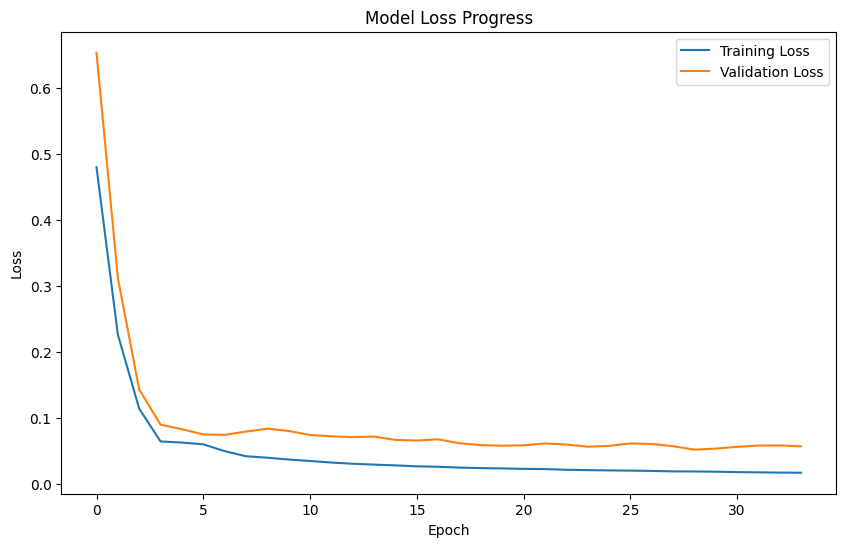

In [58]:
# Train the model
history = train_tsmixer_model(tsmixer_model, X_train, Y_train, X_test, Y_test, 
                              epochs=general_config['epochs'], 
                              batch_size=general_config['batch_size'], 
                              patience=general_config['patience'],
                              pre_trained_weights=pre_trained_weights)

1/1 [==============================] - 0s 25ms/step


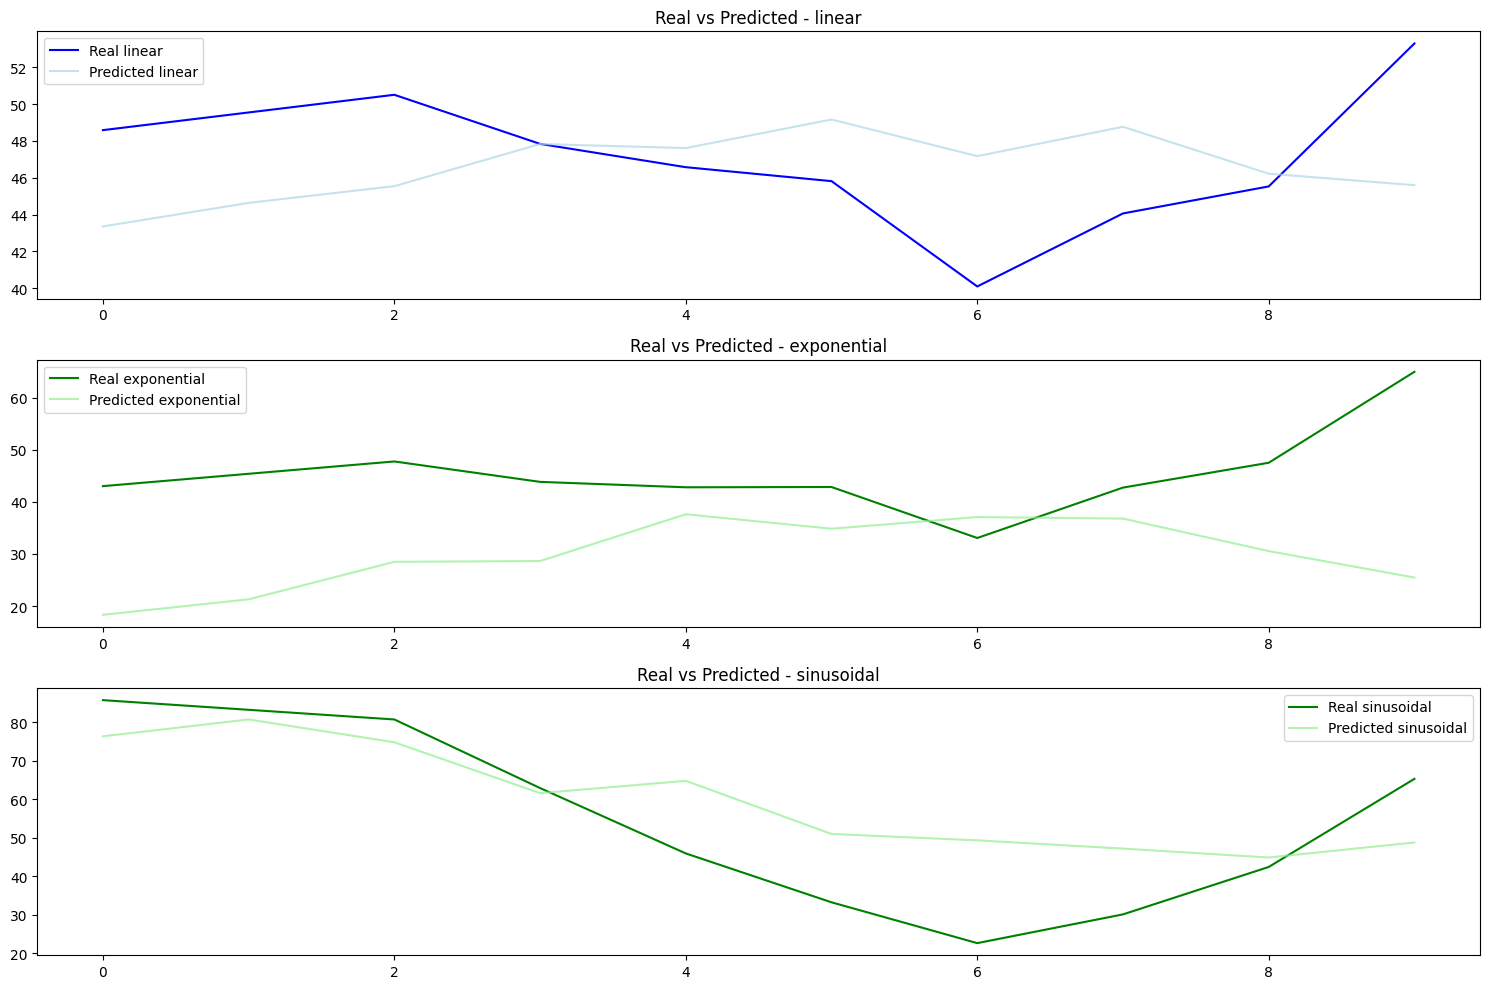

In [59]:
# Make predictions over the test set
Y_test_original, predictions_original, predictions = predict_test_set(tsmixer_model, X_test, Y_test, 
                                                                      data_scalers, general_config['features'])

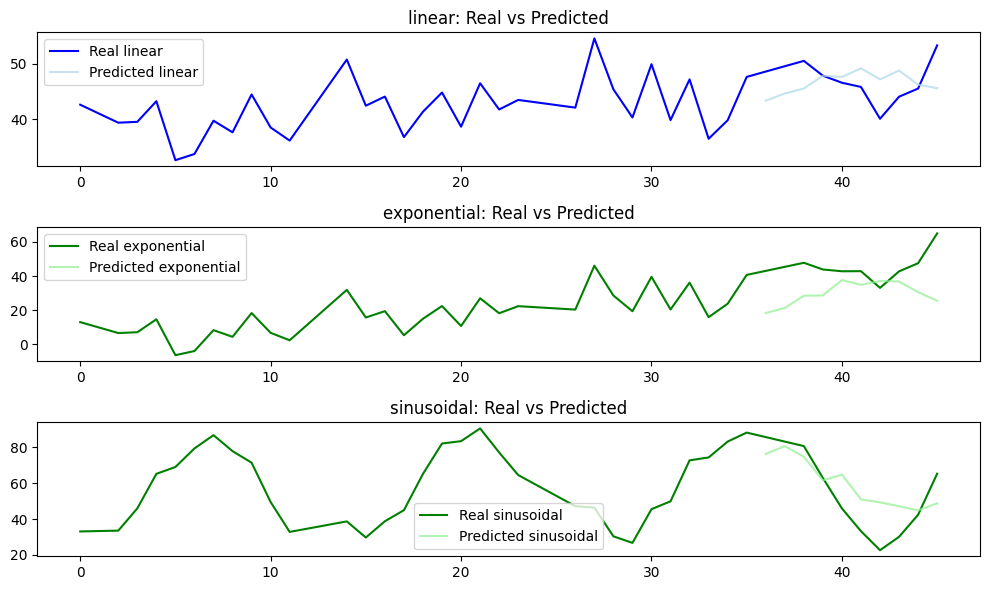

In [60]:
# Plot the test set predictions with the history of the time series
plot_test_set_predictions_with_history(Y_train, Y_test, predictions, data_scalers, general_config['features'])

In [61]:
# Metrics for the Test Set:
print("\n[Test Set] Evaluation:")
test_set_metrics = evaluate_test_set(Y_test, predictions, data_scalers, general_config['features'])


[Test Set] Evaluation:
linear - MAE: 3.964302276611329, RMSE: 4.691140118086103, MAPE: 8.429826565709163%
exponential - MAE: 16.27083132507324, RMSE: 19.430238182940283, MAPE: 33.863049088634945%
sinusoidal - MAE: 11.845537999267576, RMSE: 14.434556831416598, MAPE: 32.36648281041939%


# Backtesting

1/1 [==============================] - 0s 11ms/step


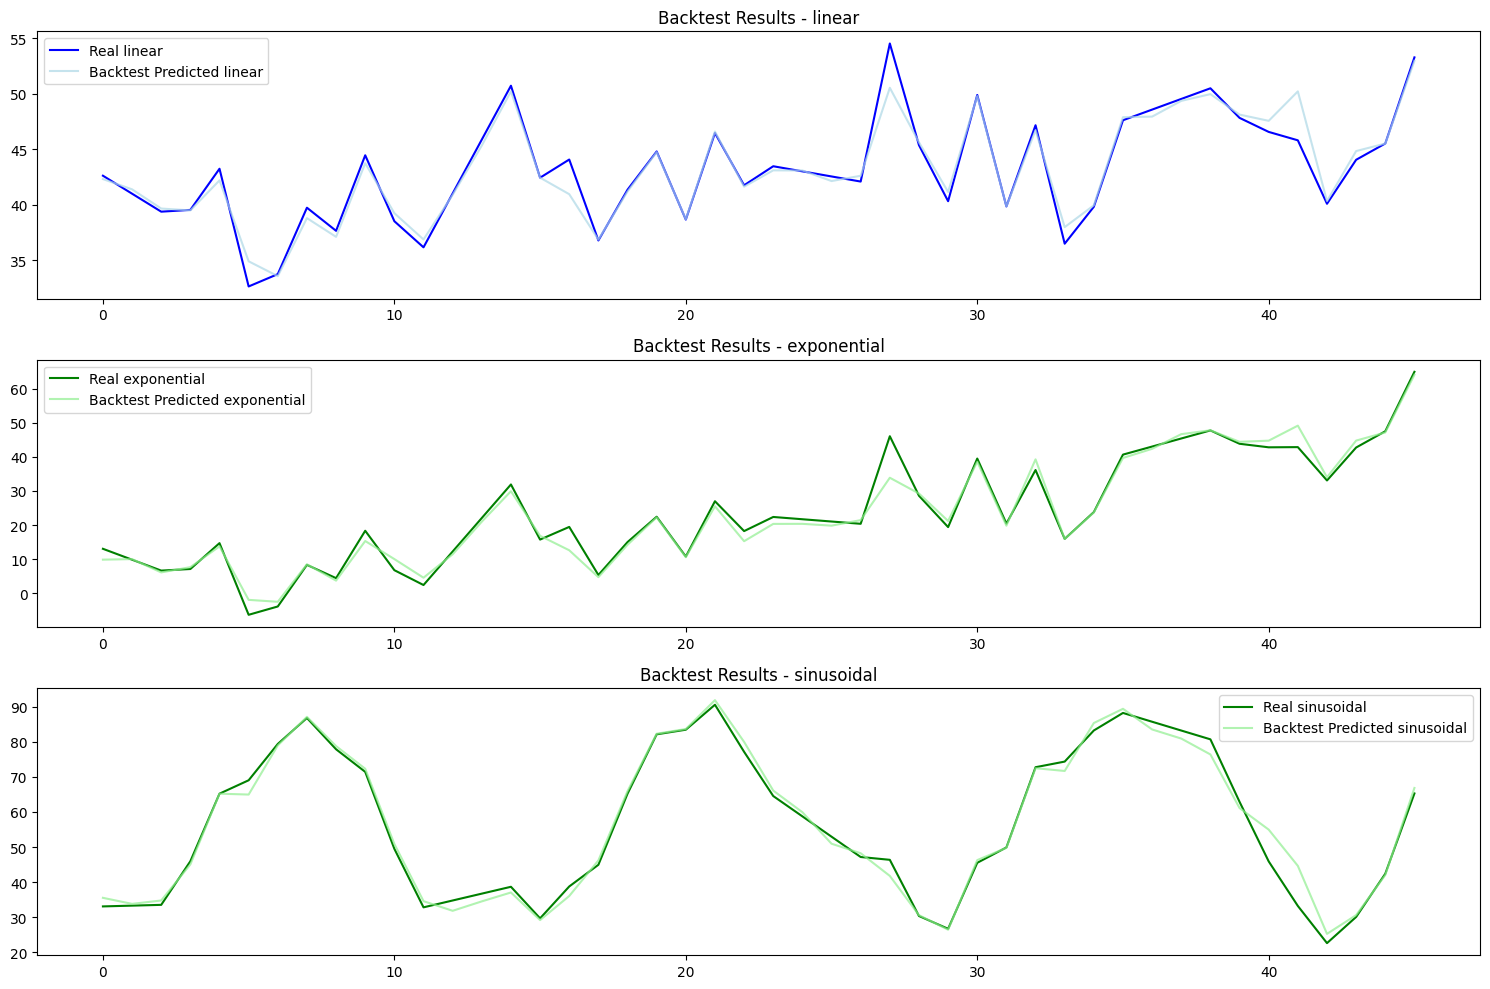

In [62]:
# Apply backtesting
predictions_bt, true_values_bt = backtest_model(tsmixer_model, X, Y, general_config['features'], data_scalers,
                                                plot_results=True, epochs=general_config['epochs'], 
                                                batch_size=general_config['batch_size'],
                                                patience=general_config['patience'])

In [63]:
# Use the evaluate function for backtesting results
print("\n[Backtest] Evaluation:")
metrics_bt = evaluate_test_set(true_values_bt, predictions_bt, data_scalers, general_config['features'])


[Backtest] Evaluation:
linear - MAE: 0.6588074227153397, RMSE: 1.1562343821030536, MAPE: 1.5213837329077107%
exponential - MAE: 1.729992126311426, RMSE: 2.7500369583001025, MAPE: 11.809944735260409%
sinusoidal - MAE: 1.8580709578140935, RMSE: 2.8184287172234885, MAPE: 4.0191495558140184%


# Future Forecast (beyond Test Set)

In [64]:
# Forecast with Production model:
forecasted_col_names = [f"forecasted_{feature}" for feature in general_config['features']]
forecasted_df = forecast_data(tsmixer_model, data, general_config['look_back'], 12, 
                              data_scalers, general_config['features'], columns=forecasted_col_names)

1/1 [==============================] - 0s 8ms/step


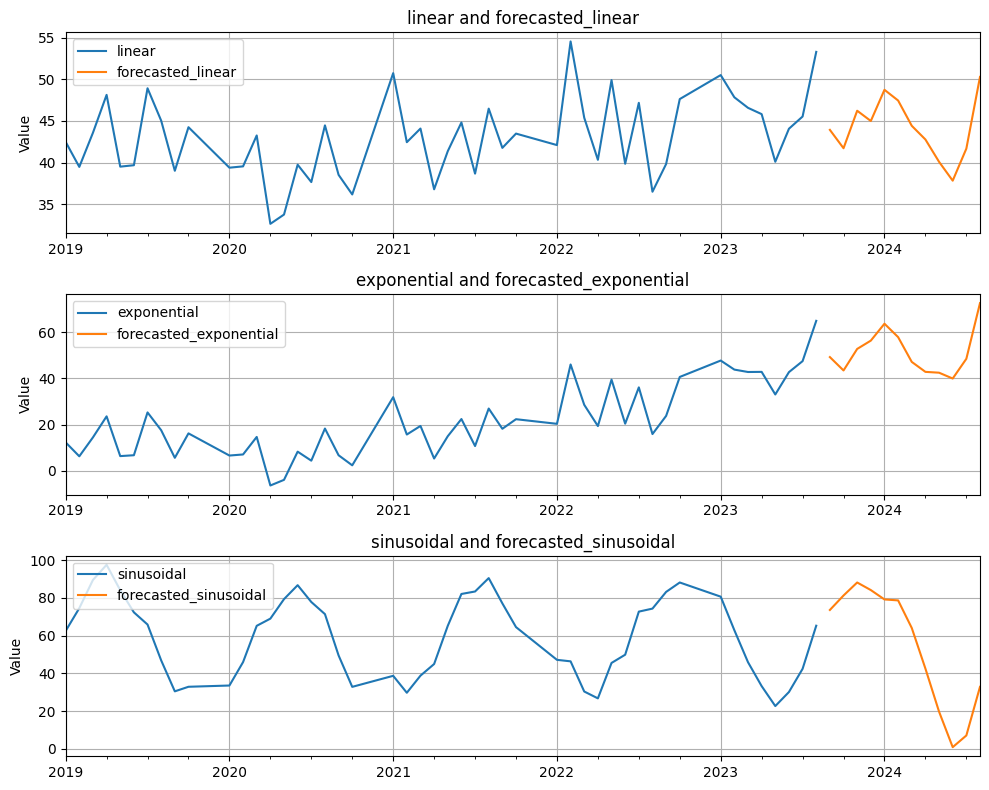

In [65]:
# Plot the forecast with history
history_and_forecast_df = pd.concat([data_original, forecasted_df], axis=0)
plot_future_forecast_with_history(history_and_forecast_df, general_config['features'])

# MLFlow Experiment Registration

In [66]:
# MLFlow Experiment Registration and model saving

# MLFlow Configuration
metrics_to_log = {
    # "Inflation - TestSet - MAE": test_set_metrics['inflacion_MAE'],
    # "LELIQs - TestSet - MAE": test_set_metrics['leliqs_MAE'],
    # "Inflation - TestSet - RMSE": test_set_metrics['inflacion_RMSE'],
    # "LELIQs - TestSet - RMSE": test_set_metrics['leliqs_RMSE'],
    # "Inflation - TestSet - MAPE": test_set_metrics['inflacion_MAPE'],
    # "LELIQs - TestSet - MAPE": test_set_metrics['leliqs_MAPE'],
    # "Inflation - Backtesting - MAE": metrics_bt['inflacion_MAE'],
    # "LELIQs - Backtesting - MAE": metrics_bt['leliqs_MAE'],
    # "Inflation - Backtesting - RMSE": metrics_bt['inflacion_RMSE'],
    # "LELIQs - Backtesting - RMSE": metrics_bt['leliqs_RMSE'],
    # "Inflation - Backtesting - MAPE": metrics_bt['inflacion_MAPE'],
    # "LELIQs - Backtesting - MAPE": metrics_bt['leliqs_MAPE']
}

artifacts_to_log = ["plots/training_loss_plot.png", 
                    "plots/test_set_predictions.png", 
                    "plots/backtesting_predictions.png", 
                    "plots/future_forecast.png"]

if general_config['register_experiment']:
    log_experiment_to_mlflow(tsmixer_model, general_config['model_name'], 
                             general_config['experiment_version'], general_config['model_artifact_name'],
                             general_config['epochs'], general_config['batch_size'], 
                             metrics_to_log, artifacts_to_log, history_and_forecast_df)
    
    print("Experiment Registered!")

# Loading Favorite Experiment Model:

In [67]:
# Loading Favorite Experiment Model:
favorite_run_id = '9812b67ea6864813893fa4b09476e7fe'
tsmixer_model = load_mlflow_experimental_model(favorite_run_id, general_config['model_artifact_name'])
print(tsmixer_model)

# Registering Model

In [68]:
if general_config['register_model']:
    mlflow.register_model(f"runs:/{favorite_run_id}/{general_config['model_artifact_name']}", 
                          f"{general_config['model_name']}_v{general_config['production_version']}")
    print("Model Registered!")

# Fetching the MLflow Model from the Model Registry

In [69]:
# Loading Staged Model:

tsmixer_model = load_mlflow_staged_model(general_config['model_name'], 
                                         general_config['production_version'], 
                                         general_config['stage'])
print(tsmixer_model)

mlflow.pyfunc.loaded_model:
  artifact_path: TSMixerModel3
  flavor: mlflow.sklearn
  run_id: 9812b67ea6864813893fa4b09476e7fe



# Check Model with Forecast again

1/1 [==============================] - 0s 7ms/step


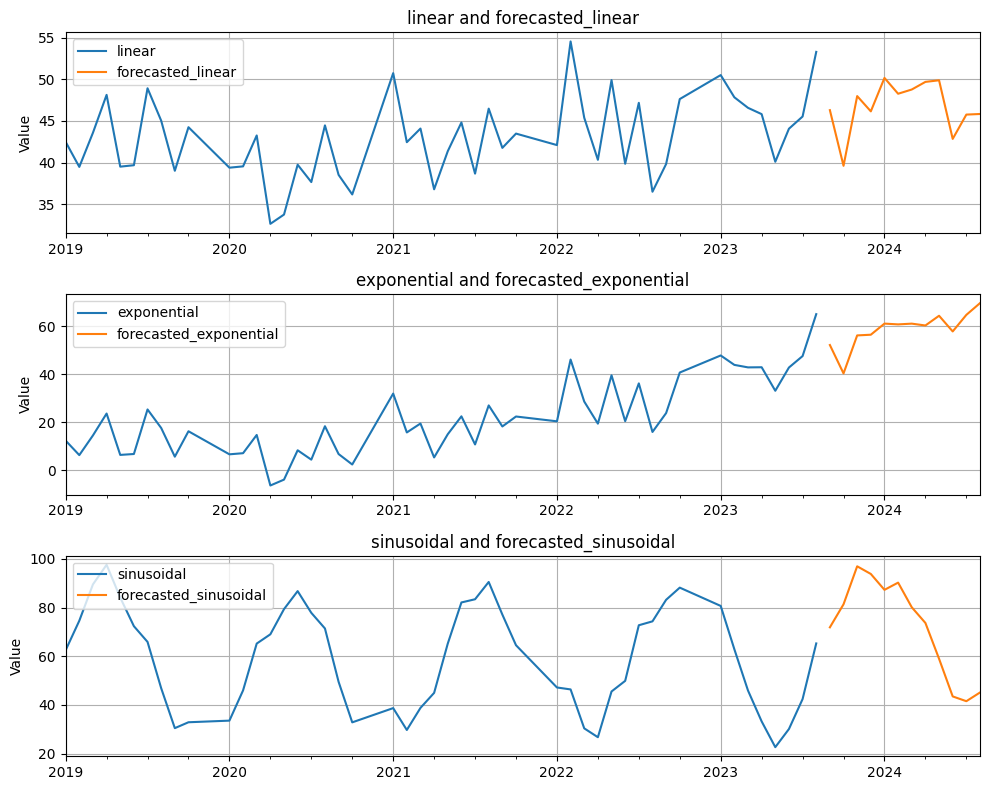

In [70]:
# Forecast with Production model:
forecasted_col_names = [f"forecasted_{feature}" for feature in general_config['features']]
forecasted_df = forecast_data(tsmixer_model, data, general_config['look_back'], 12, 
                              data_scalers, general_config['features'], columns= forecasted_col_names)

# Plot the forecast with history
history_and_forecast_df = pd.concat([data_original, forecasted_df], axis=0)
plot_future_forecast_with_history(history_and_forecast_df, general_config['features'])

# Write to Postgres

In [71]:
save_to_postgres(history_and_forecast_df, 'history_and_forecast_test_4', mode='replace')

"DataFrame successfully saved to history_and_forecast_test_4 in PostgreSQL using mode 'replace'."

In [72]:
df = read_from_postgres('history_and_forecast_test_4')

Successfully loaded table 'history_and_forecast_test_4' from PostgreSQL.
Number of records: 68
Columns: index, linear, exponential, sinusoidal, forecasted_linear, forecasted_exponential, forecasted_sinusoidal


In [73]:
df

,index,linear,exponential,sinusoidal,forecasted_linear,forecasted_exponential,forecasted_sinusoidal
0,2019-01-01,42.4836,12.3247,62.4836,NaN,NaN,NaN
1,2019-02-01,39.4789,6.2948,74.5968,NaN,NaN,NaN
2,2019-03-01,43.5789,14.4881,89.5466,NaN,NaN,NaN
3,2019-04-01,48.1258,23.5897,97.5984,NaN,NaN,NaN
4,2019-05-01,39.5101,6.3813,84.1169,NaN,NaN,NaN
...,...,...,...,...,...,...,...
63,2024-04-01,NaN,NaN,NaN,49.683926,60.217990,73.682220
64,2024-05-01,NaN,NaN,NaN,49.876907,64.262620,58.958620
65,2024-06-01,NaN,NaN,NaN,42.841278,57.741590,43.481964
66,2024-07-01,NaN,NaN,NaN,45.758358,64.635100,41.518177


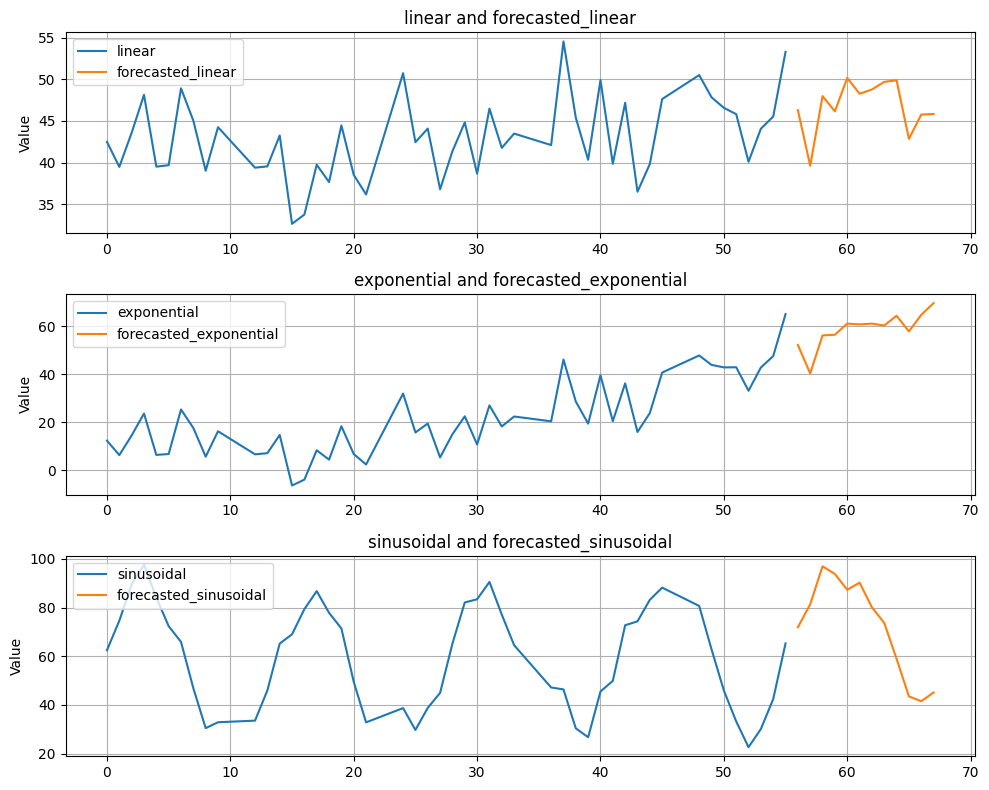

In [74]:
plot_future_forecast_with_history(df, general_config['features'])